In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys, time, json, copy
import matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /lustre/work/sunao.sugiyama/package/dark_emulator_public/dark_emulator/__init__.py


In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


# Year 1, single source bin analysis

In [4]:
%%time
dirname = './single_source_ClY1'
fisher2x2pt = hsc3x2pt.getFisher(dirname, power_b1, probes=['w', 'gamma_t'], 
                                 label='2x2pt (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})
fisherCS = hsc3x2pt.getFisher(dirname, power_b1, probes=['xi+','xi-'], 
                              label='Cosmic Shear (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})
fisher3x2pt = hsc3x2pt.getFisher(dirname, power_b1, 
                                 label='3x2pt (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})

cov.shape = (66, 66), dim(data)=(66,)
cov.shape = (17, 17), dim(data)=(17,)
skip b1lowz because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass2 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamaglowz because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass2 because this is lens galaxy param, while probes does not include any lens related probe.
cov.shape = (83, 83), dim(data)=(83,)
CPU times: user 7.17 s, sys: 1.19 s, total: 8.36 s
Wall time: 8.42 s


In [5]:
fisher2x2ptPrior = fisher2x2pt.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisher3x2ptPrior = fisher3x2pt.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisherCSPrior = fisherCS.addPrior([0.00038, 0.0042, 0.1, 0.01], 
                                  ['omega_b', 'ns', 
                                   'dzph','dm'], label='Prior')

| | $\Omega_m$ | $\sigma_8$ |
|------|------------|------------|
|HSCY1 CS Hamana| $0.346^{+0.052}_{-0.1}$ | $0.766^{+0.110}_{-0.098}$ |
|HSCY1 2x2pt Sugiyama| $0.283^{+0.12}_{-0.035}$ | $0.85^{+0.16}_{-0.11}$ |

In [6]:
hsc3x2pt.compare1Sigma([fisherCS, fisherCSPrior, fisher2x2pt, fisher2x2ptPrior, fisher3x2pt, fisher3x2ptPrior], 
                       ['Omega_de', 'sigma8', 'b1lowz', 'dm', 'dzph'])

,$\Omega_\mathrm{de}$,$\sigma_8$,"$b_\mathrm{1,LOWZ}$",$\Delta m$,$\Delta z_\mathrm{ph}$
"Cosmic Shear (Y1, 1)",10.84057,7.62233,-1.00000,7.78239,10.49855
"Cosmic Shear (Y1, 1) + Prior",0.14283,0.16582,-1.00000,0.01000,0.09967
"2x2pt (Y1, 1)",0.08035,0.51424,1.11734,1.40332,1.99605
"2x2pt (Y1, 1) + Prior",0.05941,0.13620,0.28069,0.01000,0.09710
"3x2pt (Y1, 1)",0.06860,0.20335,0.63052,0.66001,0.55936
"3x2pt (Y1, 1) + Prior",0.04610,0.04842,0.10861,0.00999,0.08178


In [7]:
corner = hsc3x2pt.corner_class()

b1lowz is not included any fisher analysis. Omitting it.


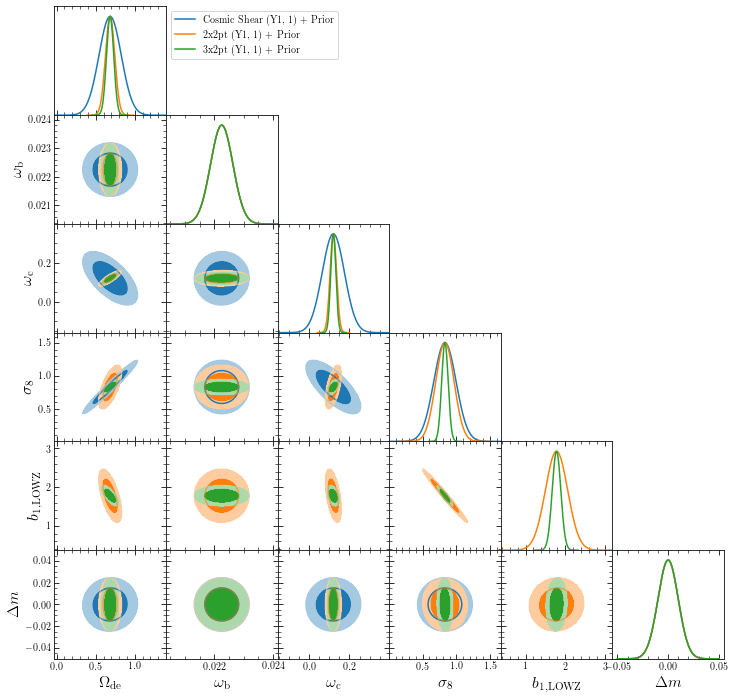

In [8]:
fig = corner.plot_corner([fisherCSPrior, fisher2x2ptPrior, fisher3x2ptPrior], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f2x2ptY1singlePrior_fCSY1singlePrior_f3x2ptY1singlePrior.pdf')

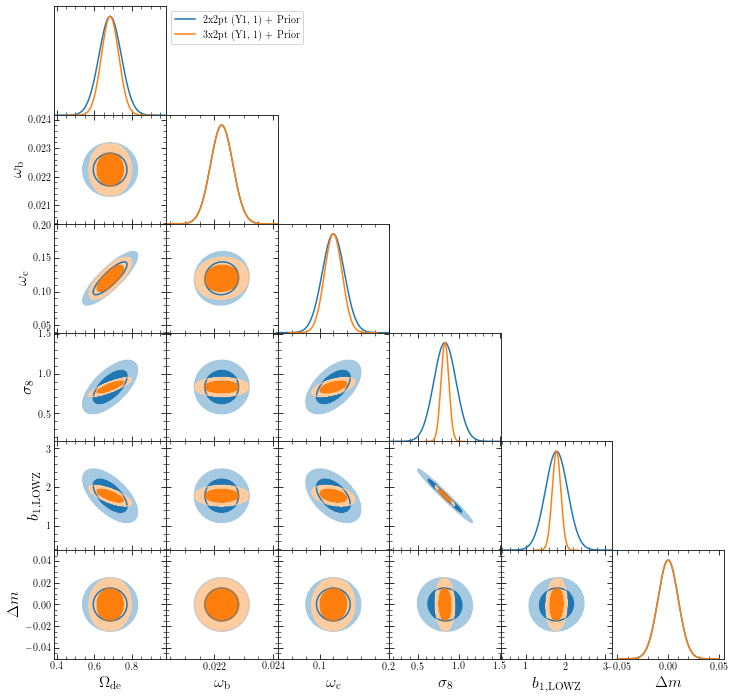

In [9]:
fig = corner.plot_corner([fisher2x2ptPrior, fisher3x2ptPrior], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm'], 
                         figsize_ratio=2, usetex=True)

In [10]:
chainReader = hsc3x2pt.chain_reader_class()
samplesHSCY12x2ptRealData = chainReader.getHSCY12x2ptSugiyama()

Removed no burn in


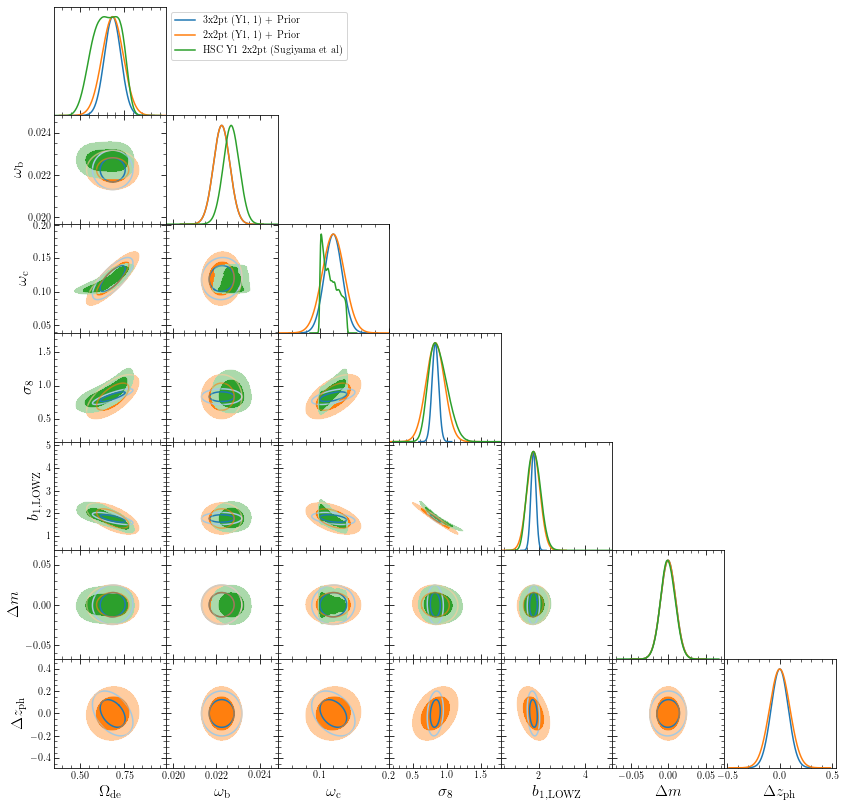

In [11]:
fig = corner.plot_corner([fisher3x2ptPrior, fisher2x2ptPrior, samplesHSCY12x2ptRealData], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm', 'dzph'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f3x2ptY1singlePrior_f2x2ptY1singlePrior_real2x2ptY1.pdf')

### clustering alone analysis

In [12]:
dirname = './single_source_ClY1'
fisherClustering = hsc3x2pt.getFisher(dirname, power_b1, probes=['w'], 
                                      label='clustering alone (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})

fisherClusteringPrior = fisherClustering.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                                ['omega_b', 'ns', 
                                                 'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                                 'dzph','dm'], label='Prior')

fisherLensing = hsc3x2pt.getFisher(dirname, power_b1, probes=['gamma_t'], 
                                      label='g-g lensing alone (Y1, 1)', Omega_s={'gamma_t':140, 'xi':140})

fisherLensingPrior = fisherLensing.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                                ['omega_b', 'ns', 
                                                 'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                                 'dzph','dm'], label='Prior')

cov.shape = (42, 42), dim(data)=(42,)
cov.shape = (24, 24), dim(data)=(24,)


In [13]:
hsc3x2pt.compare1Sigma([fisherClusteringPrior, fisherLensingPrior], 
                       ['Omega_de', 'sigma8', 'b1lowz', 'b1cmass1', 'b1cmass2', 'dm', 'dzph'])

,$\Omega_\mathrm{de}$,$\sigma_8$,"$b_\mathrm{1,LOWZ}$","$b_\mathrm{1,CMASS1}$","$b_\mathrm{1,CMASS2}$",$\Delta m$,$\Delta z_\mathrm{ph}$
"clustering alone (Y1, 1) + Prior",0.06630,0.56153,1.15078,1.33773,1.45852,0.01000,0.10000
"g-g lensing alone (Y1, 1) + Prior",1.47378,1.11516,7.99545,8.99261,10.03400,0.01000,0.10000


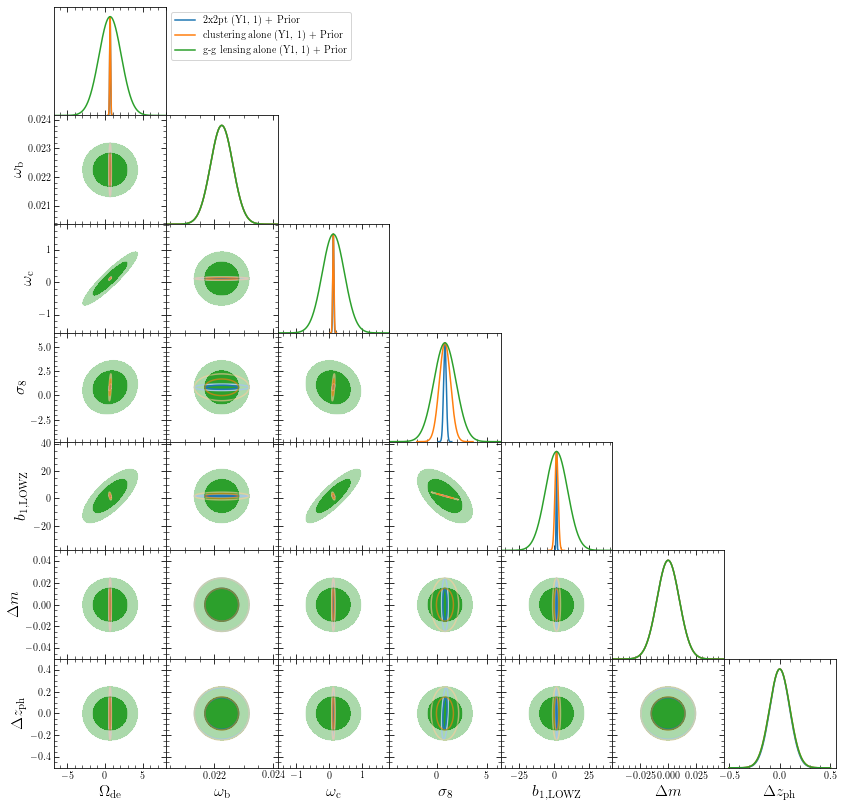

In [14]:
corner = hsc3x2pt.corner_class()
fig = corner.plot_corner([fisher2x2ptPrior, fisherClusteringPrior, fisherLensingPrior], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm', 'dzph'], 
                         figsize_ratio=2, usetex=True)
#fig.export('figures/corner_temp.pdf')

# Year 1, double source bin analysis

In [15]:
%%time
dirname = './double_source_ClY1'
fisher2x2pt2 = hsc3x2pt.getFisher(dirname, power_b1, probes=['w', 'gamma_t'], 
                                  label='2x2pt (Y1, 2)', Omega_s={'gamma_t':140, 'xi':140})
fisherCS2 = hsc3x2pt.getFisher(dirname, power_b1, probes=['xi+','xi-'], 
                               label='Cosmic Shear (Y1, 2)', Omega_s={'gamma_t':140, 'xi':140})
fisher3x2pt2 = hsc3x2pt.getFisher(dirname, power_b1, 
                                  label='3x2pt (Y1, 2)', Omega_s={'gamma_t':140, 'xi':140})

cov.shape = (90, 90), dim(data)=(90,)
cov.shape = (51, 51), dim(data)=(51,)
skip b1lowz because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass2 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamaglowz because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass2 because this is lens galaxy param, while probes does not include any lens related probe.
cov.shape = (141, 141), dim(data)=(141,)
CPU times: user 19.3 s, sys: 6.76 s, total: 26.1 s
Wall time: 26.7 s


In [16]:
fisher2x2pt2Prior = fisher2x2pt2.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisher3x2pt2Prior = fisher3x2pt2.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisherCS2Prior = fisherCS2.addPrior([0.00038, 0.0042, 0.1, 0.01], 
                                  ['omega_b', 'ns', 
                                   'dzph','dm'], label='Prior')

In [17]:
hsc3x2pt.compare1Sigma([fisherCS2, fisherCS2Prior, fisher2x2pt2, fisher2x2pt2Prior, fisher3x2pt2, fisher3x2pt2Prior], 
                       ['Omega_de', 'sigma8', 'b1lowz', 'dm', 'dzph1', 'dzph2'])

,$\Omega_\mathrm{de}$,$\sigma_8$,"$b_\mathrm{1,LOWZ}$",$\Delta m$,"$\Delta z_\mathrm{ph,1}$","$\Delta z_\mathrm{ph,2}$"
"Cosmic Shear (Y1, 2)",1.63897,0.64781,-1.00000,3.00927,0.73959,1.06574
"Cosmic Shear (Y1, 2) + Prior",0.49260,0.35931,-1.00000,0.01000,0.60506,0.71699
"2x2pt (Y1, 2)",0.08023,0.50939,1.09976,1.34330,1.40126,2.52257
"2x2pt (Y1, 2) + Prior",0.06074,0.23391,0.48216,0.01000,0.28541,0.54466
"3x2pt (Y1, 2)",0.06798,0.16579,0.51027,0.39294,0.19423,0.27211
"3x2pt (Y1, 2) + Prior",0.04874,0.04748,0.10837,0.00999,0.10333,0.13494


In [18]:
hsc3x2pt.compare1Sigma([fisher2x2pt2Prior, fisher2x2ptPrior], 
                       ['Omega_de', 'sigma8', 'b1lowz', 'dm', 'dzph1', 'dzph2'])

,$\Omega_\mathrm{de}$,$\sigma_8$,"$b_\mathrm{1,LOWZ}$",$\Delta m$,"$\Delta z_\mathrm{ph,1}$","$\Delta z_\mathrm{ph,2}$"
"2x2pt (Y1, 2) + Prior",0.06074,0.23391,0.48216,0.01000,0.28541,0.54466
"2x2pt (Y1, 1) + Prior",0.05941,0.13620,0.28069,0.01000,-1.00000,-1.00000


In [19]:
corner = hsc3x2pt.corner_class()

b1lowz is not included any fisher analysis. Omitting it.


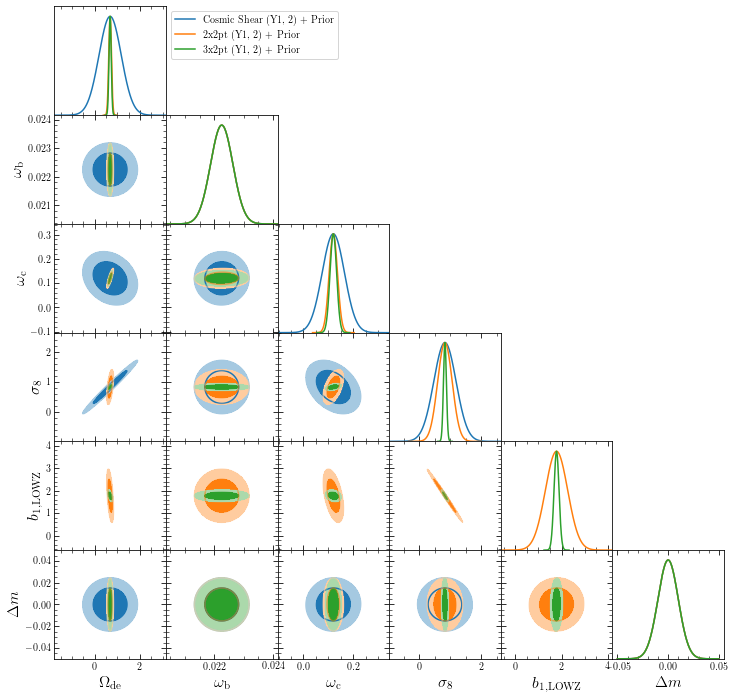

In [20]:
fig = corner.plot_corner([fisherCS2Prior, fisher2x2pt2Prior, fisher3x2pt2Prior], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f2x2ptY1doublePrior_fCSY1doublePrior_f3x2ptY1doublePrior.pdf')

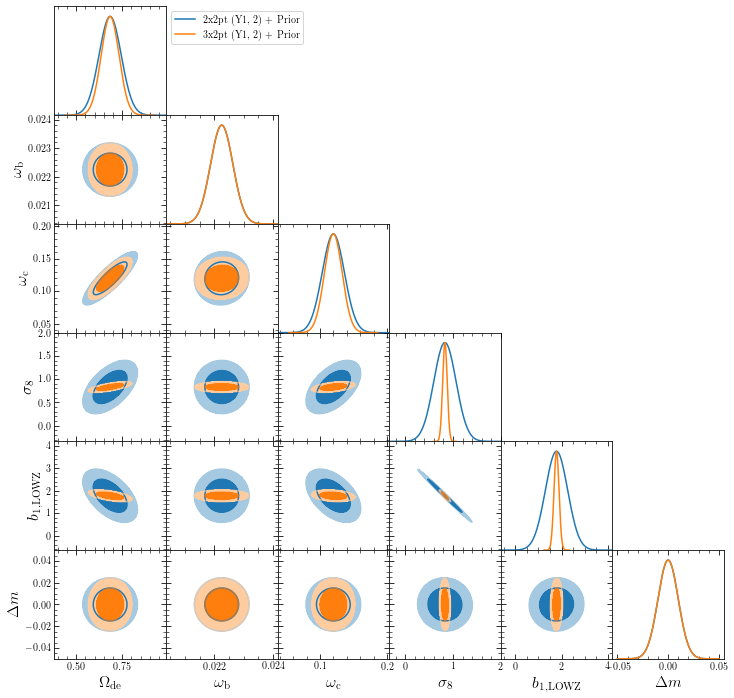

In [21]:
fig = corner.plot_corner([fisher2x2pt2Prior, fisher3x2pt2Prior], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm'], 
                         figsize_ratio=2, usetex=True)

## double vs single source anlaysis

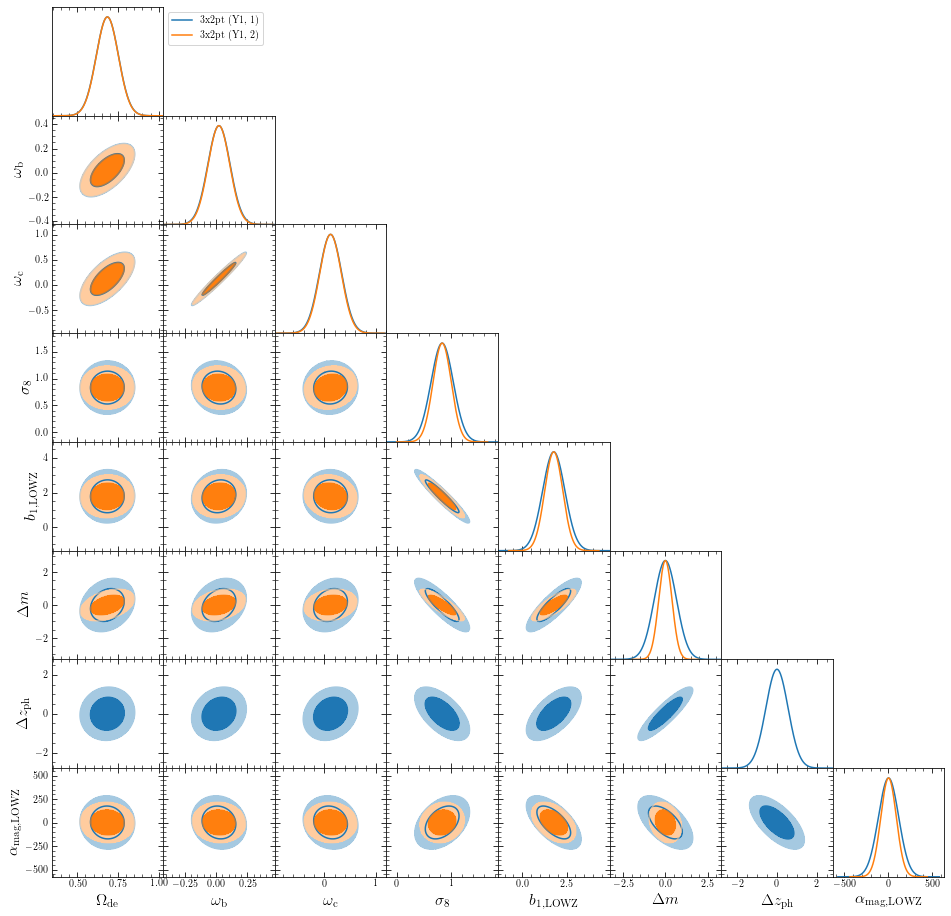

In [39]:
fig = corner.plot_corner([fisher3x2pt, fisher3x2pt2], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm', 'dzph', 'alphamaglowz'], 
                         figsize_ratio=2, usetex=True)
#fig.export('figures/corner_f3x2ptY1singlePrior_f3x2ptY1doublePrior.pdf')

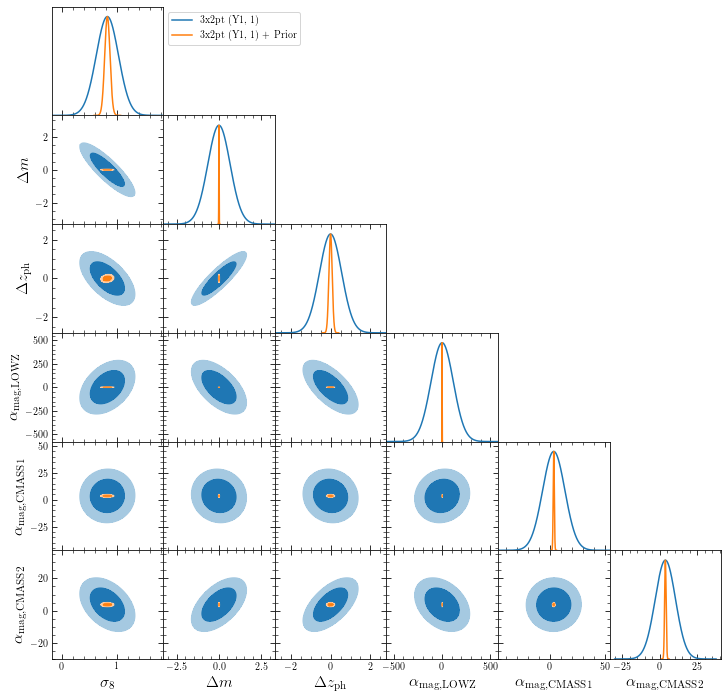

In [40]:
fig = corner.plot_corner([fisher3x2pt, fisher3x2ptPrior], 
                         ['sigma8', 'dm', 'dzph', 'alphamaglowz', 'alphamagcmass1', 'alphamagcmass2'], 
                         figsize_ratio=2, usetex=True)

In [34]:
hsc3x2pt.compare1Sigma(fisher3x2pt2, sigma_scale=140/400.0)

using dark_emulator at  /lustre/work/sunao.sugiyama/package/dark_emulator_public/dark_emulator/__init__.py


,$\Omega_\mathrm{de}$,"$\alpha_\mathrm{mag, CMASS1}$","$\alpha_\mathrm{mag, CMASS2}$","$\alpha_\mathrm{mag, LOWZ}$","$b_\mathrm{1,CMASS1}$","$b_\mathrm{1,CMASS2}$","$b_\mathrm{1,LOWZ}$",$\Delta m$,"$\Delta z_\mathrm{ph,1}$","$\Delta z_\mathrm{ph,2}$",$n_\mathrm{s}$,$\omega_\mathrm{b}$,$\omega_\mathrm{c}$,$\sigma_8$
"3x2pt (Y1, 2)",0.02379,3.46123,2.03459,30.84820,0.18573,0.20120,0.17860,0.13753,0.06798,0.09524,0.10422,0.03046,0.07338,0.05802


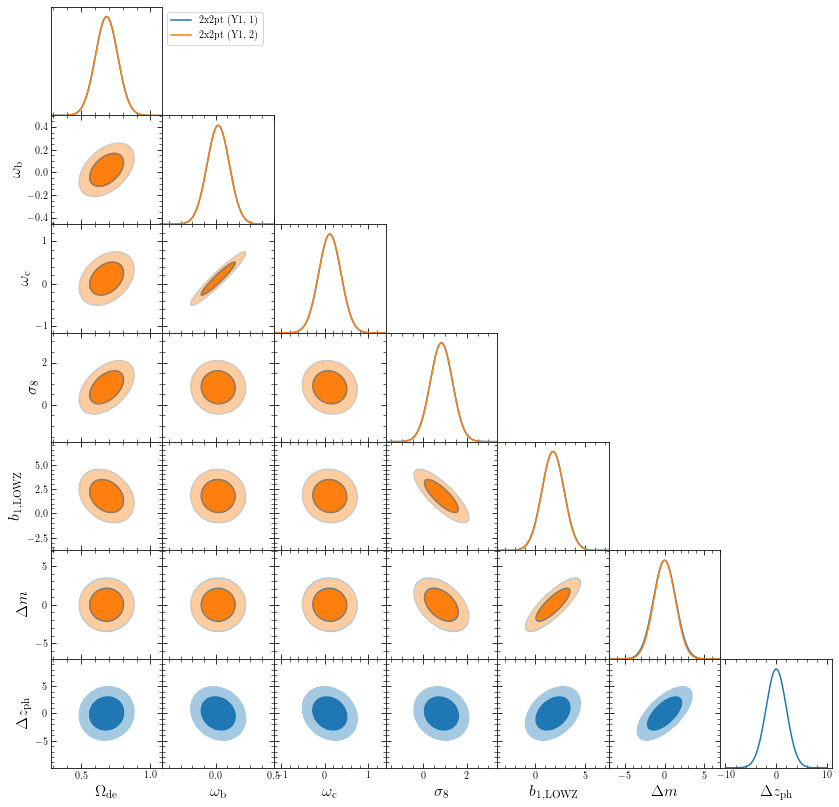

In [26]:
fig = corner.plot_corner([fisher2x2pt, fisher2x2pt2], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm', 'dzph'], 
                         figsize_ratio=2, usetex=True)

b1lowz is not included any fisher analysis. Omitting it.
b1lowz is not included any fisher analysis. Omitting it.


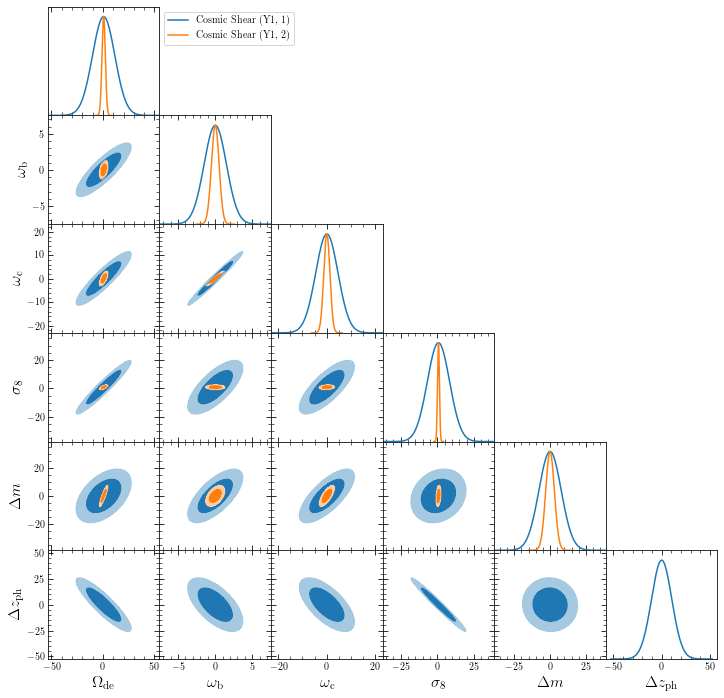

In [27]:
fig = corner.plot_corner([fisherCS, fisherCS2], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8', 'b1lowz', 'dm', 'dzph'], 
                         figsize_ratio=2, usetex=True)

# Cosmic Shear alone: tomography with quadruple sources

In [23]:
%%time
dirname = './quadruple_source_ClY1'
fisherCSquad = hsc3x2pt.getFisher(dirname, power_b1, 
                                  label='CS (quad)', Omega_s={'gamma_t':140, 'xi':140})

cov.shape = (170, 170), dim(data)=(170,)
CPU times: user 33.5 s, sys: 12.8 s, total: 46.3 s
Wall time: 47.1 s


In [24]:
corner = hsc3x2pt.corner_class()

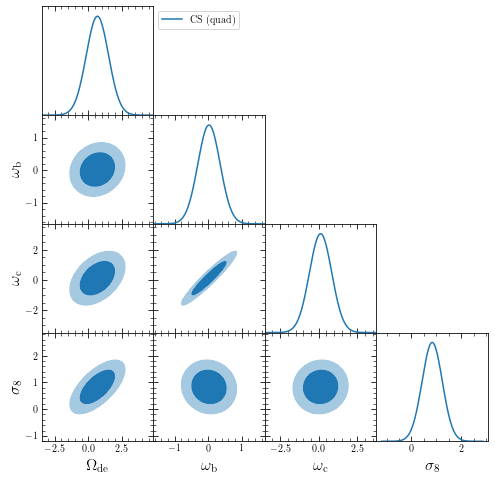

In [25]:
fig = corner.plot_corner([fisherCSquad], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8'],
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_fCSY1quad.pdf')

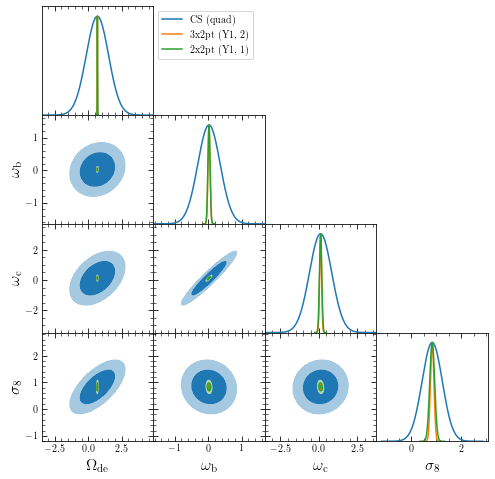

In [26]:
fig = corner.plot_corner([fisherCSquad, fisher3x2pt2, fisher2x2pt], 
                         ['Omega_de', 'omega_b', 'omega_c', 'sigma8'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_fCSY1quad_f3x2ptY1double_f2x2ptY1single.pdf')

# Questions
- multiplicative biasは各source redshift binに振るのではないのか？
- source 4つにすると手前のsource bin redshiftがlens sampleと重なるのでモデリングが大変→やらない、という話だったが、では4 source redshift binをとって手前の2 source samplesはcosmic shear tomographyにのみ使ってg-g lensingに使わない、というのはどうか？(Fisherできる。)

## hot to make joint Fisher

using dark_emulator at  /lustre/work/sunao.sugiyama/package/dark_emulator_public/dark_emulator/__init__.py


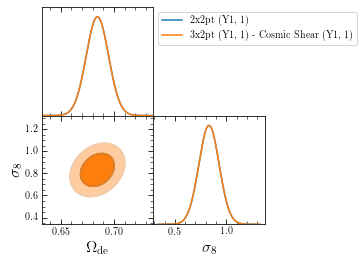

In [48]:
fisherNew = fisher3x2pt - fisherCS

corner.plot_corner([fisher2x2pt, fisherNew], ['Omega_de', 'sigma8'], 
                   figsize_ratio=2, usetex=True)

In [49]:
fisherNew = fisher2x2pt + fisherCS

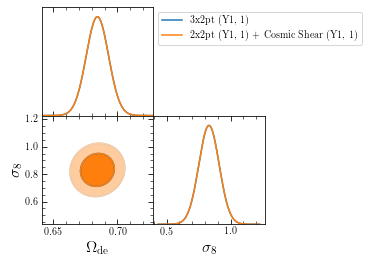

In [50]:
corner.plot_corner([fisher3x2pt, fisherNew], ['Omega_de', 'sigma8'], 
                   figsize_ratio=2, usetex=True)